In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
mh_reddit = pd.read_csv('/content/drive/MyDrive/Dissertation Datasets/Datasets/Reddit/MHData_Reddit.csv')
mh_twitter = pd.read_csv('/content/drive/MyDrive/Dissertation Datasets/Datasets/Twitter/MHData_Twitter.csv')

In [7]:
mh_reddit.head()

title  score       id  \
0           r/MentalHealth is looking for moderators      6  1e297nd   
1                         Politics and Mental Health     13  1e1m1i1   
2                        Is my friend being groomed?    111  1e7xgrs   
3                                 I hate being a man    138  1e7prs0   
4  Why do people casually diagnose others with me...     12  1e7yfyr   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/mentalhealth/comments...          0  1.720874e+09   
1  https://www.reddit.com/r/mentalhealth/comments...          4  1.720802e+09   
2  https://www.reddit.com/r/mentalhealth/comments...         38  1.721487e+09   
3  https://www.reddit.com/r/mentalhealth/comments...         58  1.721459e+09   
4  https://www.reddit.com/r/mentalhealth/comments...          6  1.721490e+09   

                                                body  
0  Hey r/mentalhealth! We're looking to grow our ...  
1  Hello friends!\n\nThe team has noticed an incr...  
2  My friend, whos 15 this year, has a ballet tea...  
3  I hate being a boy so fucking much.\n\nI'm gay...  
4  Im geniunely annoyed and this is kinda of a ra...

In [8]:
mh_reddit.shape

(21365, 7)

In [9]:
mh_twitter.head()

user_id           created_at  \
0  7.865930e+17  02/23/2020 03:10:21   
1  7.865930e+17  02/22/2020 00:54:18   
2  2.811850e+07  02/23/2020 02:35:49   
3  2.811850e+07  02/23/2020 03:10:14   
4  1.175070e+18  02/23/2020 03:10:12   

                                                text  
0  @katiecouric We're hoping you can do for #lung...  
1  @katiecouric We're hoping you can do for #lung...  
2  The scars aren't always visible. The pain can ...  
3  Find balance.  Failure is ok.  Giving up is no...  
4  <U+0001F64F>\r\n\r\nI Meditate\r\nI Pray\r\nI ...

In [10]:
mh_twitter.shape

(23005, 3)

# **1.0 Initial Preprocessing**

In [11]:
# Removing duplicates and unnecessary columns

# Twitter Data
mh_twitter_clean1 = mh_twitter.drop_duplicates(subset='text').drop(columns=['user_id', 'created_at'])

In [13]:
mh_twitter_clean1.shape

(11920, 1)

In [14]:
mh_twitter_clean1.head()

text
0  @katiecouric We're hoping you can do for #lung...
2  The scars aren't always visible. The pain can ...
3  Find balance.  Failure is ok.  Giving up is no...
4  <U+0001F64F>\r\n\r\nI Meditate\r\nI Pray\r\nI ...
5  <U+0001F441><U+FE0F>\r\n\r\nNot all disabiliti...

In [15]:
# Reddit Data (removing duplicates, dropping irrelevant columns and renaming "body" to "text")
mh_reddit_clean1 = mh_reddit.drop_duplicates(subset='body')
mh_reddit_clean1 = mh_reddit_clean1.drop(columns=['title', 'score', 'id', 'url', 'comms_num', 'created'])
mh_reddit_clean1 = mh_reddit_clean1.rename(columns={'body': 'text'})

In [16]:
mh_reddit_clean1.shape

(20573, 1)

In [17]:
mh_reddit_clean1.head()

text
0  Hey r/mentalhealth! We're looking to grow our ...
1  Hello friends!\n\nThe team has noticed an incr...
2  My friend, whos 15 this year, has a ballet tea...
3  I hate being a boy so fucking much.\n\nI'm gay...
4  Im geniunely annoyed and this is kinda of a ra...

In [22]:
# Checking for null values in the Reddit dataset
print(mh_reddit_clean1.isnull().sum())


text    1
dtype: int64


In [23]:
# Checking for null values in the Twitter dataset
print(mh_twitter_clean1.isnull().sum())


text    0
dtype: int64


In [24]:
# removing nulls in the Reddit dataset
mh_reddit_clean1 = mh_reddit_clean1.dropna()

In [25]:
print(mh_reddit_clean1.isnull().sum())

text    0
dtype: int64


In [27]:
# Creating and removing custom list of keywords indicating organisational or governmental content
custom_keywords = [
    'awareness', 'gov', 'official', 'ministry', 'our',
    'organization', 'organisation', 'follow', 'donate', 'we need' , 'government',
    'startup', 'contest', 'initiative', 'department', 'movement', 'organize','organise', 'workshop',
    'conference', 'seminar', 'study', 'research', 'services', 'tickets', 'suicideprevention',
    'campus', 'program', 'reports', 'survey', 'statistics', 'industry', 'invited',
    'join', 'series',  'register', 'enroll', 'launching', 'launch'
]

In [28]:
# Function to check if a row contains any of the custom keywords
def contains_keywords(text, keywords):
    for keyword in keywords:
        if keyword.lower() in text.lower():
            return True
    return False


In [30]:
# Apply the function to remove rows from Twitter dataset
mh_twitter_clean1 = mh_twitter_clean1[~mh_twitter_clean1['text'].apply(lambda x: contains_keywords(x, custom_keywords))]

# Apply the function to remove rows from Reddit dataset
mh_reddit_clean1 = mh_reddit_clean1[~mh_reddit_clean1['text'].apply(lambda x: contains_keywords(x, custom_keywords))]

In [31]:
# Check the results after removing rows
print(f"Twitter data shape after filtering: {mh_twitter_clean1.shape}")
print(f"Reddit data shape after filtering: {mh_reddit_clean1.shape}")


Twitter data shape after filtering: (6013, 1)
Reddit data shape after filtering: (12323, 1)


# 2.0  **Further preprocessing**: Removing mentions, special characters and URLS; converting to lower case; removing stopwords; Tokenisation and Lemmatisation

In [42]:
def preprocess_text(text):
 # Remove Unicode emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # Flags
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental symbols
        "\U00002600-\U000026FF"  # Misc symbols
        "\U000025A0-\U00002BEF"  # Various symbols
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

 # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
 # Lowercase
    text = text.lower()
 # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
 # Remove user mentions
    text = re.sub(r'@\w+', '', text)
 # Tokenise
    tokens = nltk.word_tokenize(text)
 # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
 # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
 # Join tokens back to string
    clean_text = ' '.join(tokens)
    return clean_text

In [43]:
# Apply preprocessing to Twitter dataset
mh_twitter_clean1['clean_text'] = mh_twitter_clean1['text'].apply(preprocess_text)

In [44]:
mh_twitter_clean1['clean_text'].shape

(6013,)

In [45]:
# Apply preprocessing to Reddit dataset
mh_reddit_clean1['clean_text'] = mh_reddit_clean1['text'].apply(preprocess_text)

In [46]:
mh_reddit_clean1['clean_text'].shape

(12323,)

In [47]:
# Display a sample of the 'text' column before preprocessing
print("Sample before preprocessing:")
print(mh_twitter_clean1['text'].head(5))


Sample before preprocessing:
2    The scars aren't always visible. The pain can ...
4    <U+0001F64F>\r\n\r\nI Meditate\r\nI Pray\r\nI ...
5    <U+0001F441><U+FE0F>\r\n\r\nNot all disabiliti...
7    Inhale peace. Exhale calm. #meditation #thedai...
8    Inner peace leads to higher consciousness. #me...
Name: text, dtype: object


In [48]:
# Display the sample of 'clean_text' after preprocessing
print("Sample after preprocessing:")
print(mh_twitter_clean1['clean_text'].head(5))

Sample after preprocessing:
2    scar arent always visible pain lie within voic...
4    uff meditate pray burn candle drink green tea ...
5    ufufef disability visible may able see schizoa...
7    inhale peace exhale calm meditation thedailyme...
8    inner peace lead higher consciousness meditati...
Name: clean_text, dtype: object


In [49]:
mh_reddit_clean1['clean_text'].shape

(12323,)

In [50]:
!pip install transformers

# 3.0 **Data Annotation (labelling emotions)**

In [54]:
# Annotate data
!pip install huggingface_hub[hf_xet]
from transformers import pipeline
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.9 MB/s eta 0:00:00


In [55]:
# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Initialise emotion classification pipeline with GPU support
classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion",
    tokenizer="bhadresh-savani/distilbert-base-uncased-emotion",
    truncation=True,
    device=device  # Set device to GPU if available, otherwise use CPU
)


Device set to use cuda:0


In [56]:
def classify_batch(texts):
    # Classify a batch of texts
    results = classifier(texts)
    return [(result['label'], result['score']) for result in results]


In [57]:
def apply_batch_processing(df, text_column, batch_size=16):
    emotions = []
    scores = []

    for i in range(0, len(df), batch_size):
        batch_texts = df[text_column].iloc[i:i+batch_size].tolist()

    # Handle empty or NaN texts
        batch_texts = [text if pd.notna(text) else "" for text in batch_texts]

    # Classify the batch
        batch_results = classify_batch(batch_texts)

    # Extend lists with batch results
        batch_emotions, batch_scores = zip(*batch_results)
        emotions.extend(batch_emotions)
        scores.extend(batch_scores)

    return pd.DataFrame({'emotion': emotions, 'score': scores})


In [ ]:
# Apply batch processing to Twitter data
mh_twitter_clean1[['emotion', 'score']] = apply_batch_processing(mh_twitter_clean1, 'clean_text')


In [59]:
# Apply batch processing to Reddit data
mh_reddit_clean1[['emotion', 'score']] = apply_batch_processing(mh_reddit_clean1, 'clean_text')

In [60]:
# Drop rows with NaN target labels in the Twitter and Reddit dataset
mh_twitter_clean1 = mh_twitter_clean1.dropna(subset=['emotion'])
mh_reddit_clean1 = mh_reddit_clean1.dropna(subset=['emotion'])

# 4.0 **Exploratory Data Analysis**

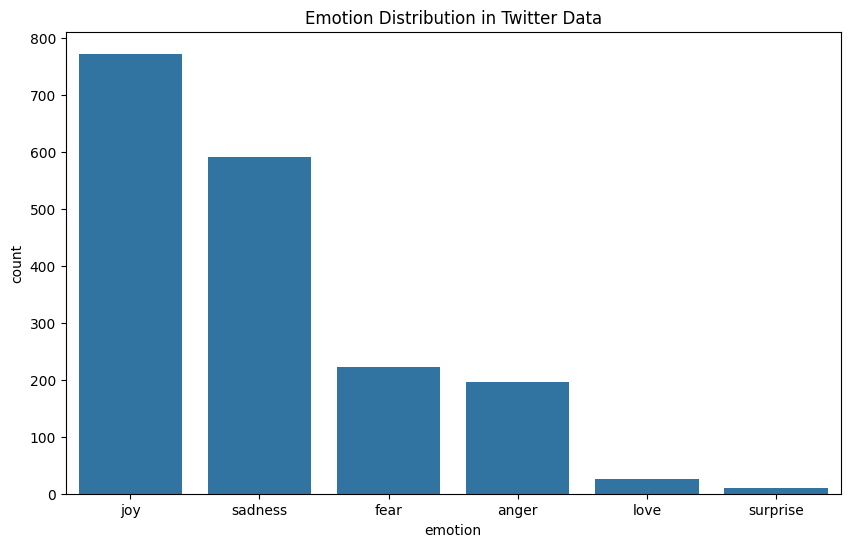

In [62]:
# Emotion distribution Plot for Twitter data
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=mh_twitter_clean1)
plt.title('Emotion Distribution in Twitter Data')
plt.show()


In [63]:
# Count occurrences of each emotion in the Twitter data
emotion_counts_twitter = mh_twitter_clean1['emotion'].value_counts()

# Print the counts for Twitter data
print("Emotion distribution in Twitter data:")
print(emotion_counts_twitter)


Emotion distribution in Twitter data:
emotion
joy         773
sadness     591
fear        223
anger       196
love         26
surprise     10
Name: count, dtype: int64


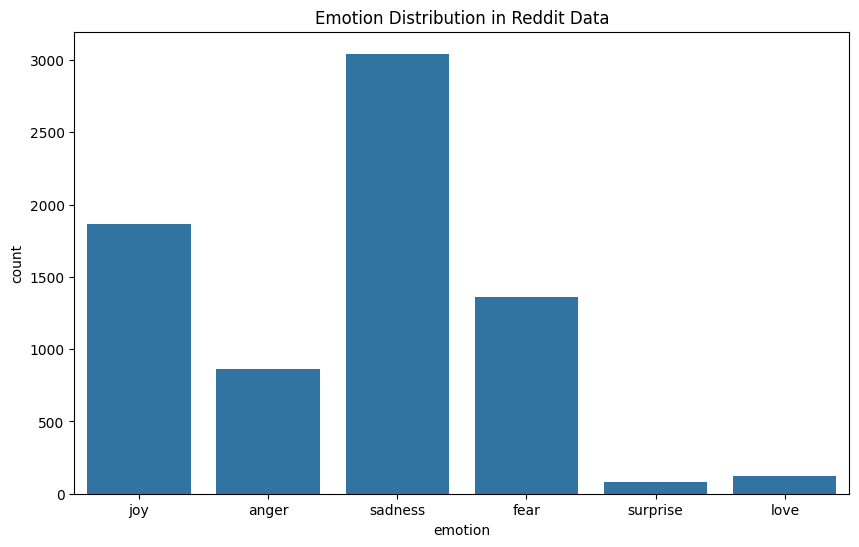

In [64]:
# Emotion distribution Plot for Reddit data
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=mh_reddit_clean1)
plt.title('Emotion Distribution in Reddit Data')
plt.show()

In [65]:
# Count occurrences of each emotion in the Reddit data (if needed)
emotion_counts_reddit = mh_reddit_clean1['emotion'].value_counts()

# Print the counts for Reddit data
print("\nEmotion distribution in Reddit data:")
print(emotion_counts_reddit)


Emotion distribution in Reddit data:
emotion
sadness     3043
joy         1865
fear        1363
anger        860
love         121
surprise      81
Name: count, dtype: int64


In [67]:
# Text Length Distribution

# Add a column for text length to both datasets
mh_twitter_clean1['text_length'] = mh_twitter_clean1['clean_text'].apply(len)
mh_reddit_clean1['text_length'] = mh_reddit_clean1['clean_text'].apply(len)

Text(0, 0.5, 'Frequency')

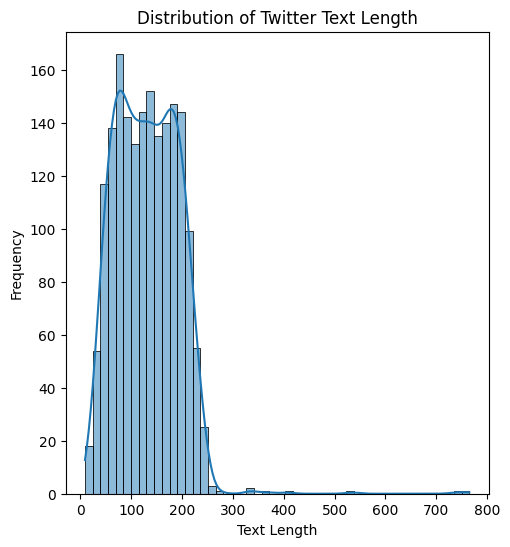

In [69]:
# Plot text length distribution for Twitter data
plt.figure(figsize=(12, 6))

# Histogram for Twitter data
plt.subplot(1, 2, 1)
sns.histplot(mh_twitter_clean1['text_length'], bins=50, kde=True)
plt.title('Distribution of Twitter Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')


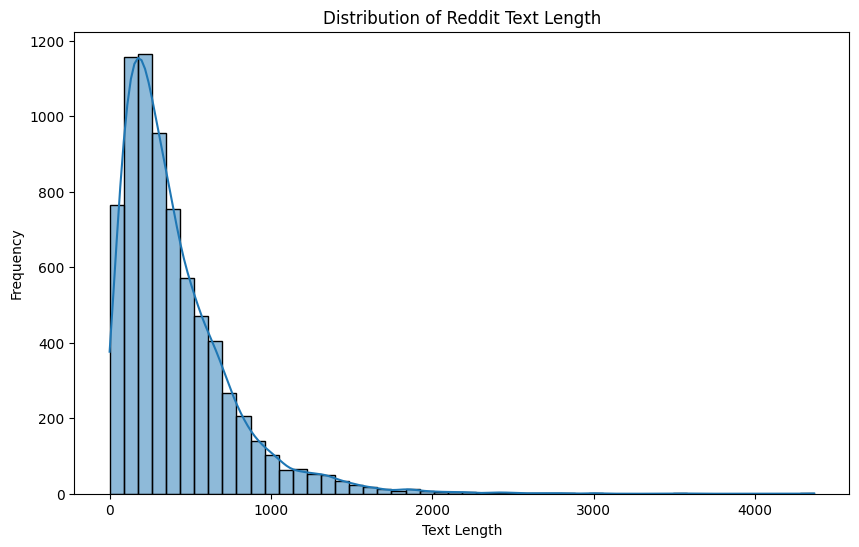

In [70]:
# Histogram for Reddit data
plt.figure(figsize=(10, 6))
sns.histplot(mh_reddit_clean1['text_length'], bins=50, kde=True)
plt.title('Distribution of Reddit Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [71]:
# Find minimum and maximum text lengths for Twitter
min_length_twitter = mh_twitter_clean1['text_length'].min()
max_length_twitter = mh_twitter_clean1['text_length'].max()

print(f"Twitter Data - Minimum Text Length: {min_length_twitter}")
print(f"Twitter Data - Maximum Text Length: {max_length_twitter}")

Twitter Data - Minimum Text Length: 9
Twitter Data - Maximum Text Length: 765


In [72]:
# Find minimum and maximum text lengths for Reddit
min_length_reddit = mh_reddit_clean1['text_length'].min()
max_length_reddit = mh_reddit_clean1['text_length'].max()

print(f"Reddit Data - Minimum Text Length: {min_length_reddit}")
print(f"Reddit Data - Maximum Text Length: {max_length_reddit}")

Reddit Data - Minimum Text Length: 0
Reddit Data - Maximum Text Length: 4366


In [73]:
# Word counts
# Calculate word count for each post in the 'clean_text' column for both datasets
mh_twitter_clean1['word_count'] = mh_twitter_clean1['clean_text'].apply(lambda x: len(x.split()))
mh_reddit_clean1['word_count'] = mh_reddit_clean1['clean_text'].apply(lambda x: len(x.split()))


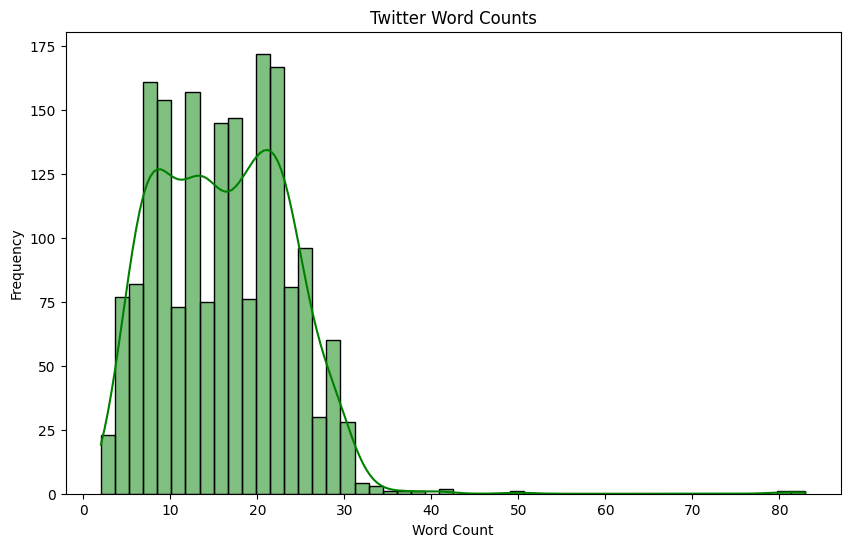

In [74]:
# Plot histogram for word count for Twitter
plt.figure(figsize=(10, 6))
sns.histplot(mh_twitter_clean1['word_count'], bins=50, kde=True, color='green')
plt.title('Twitter Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

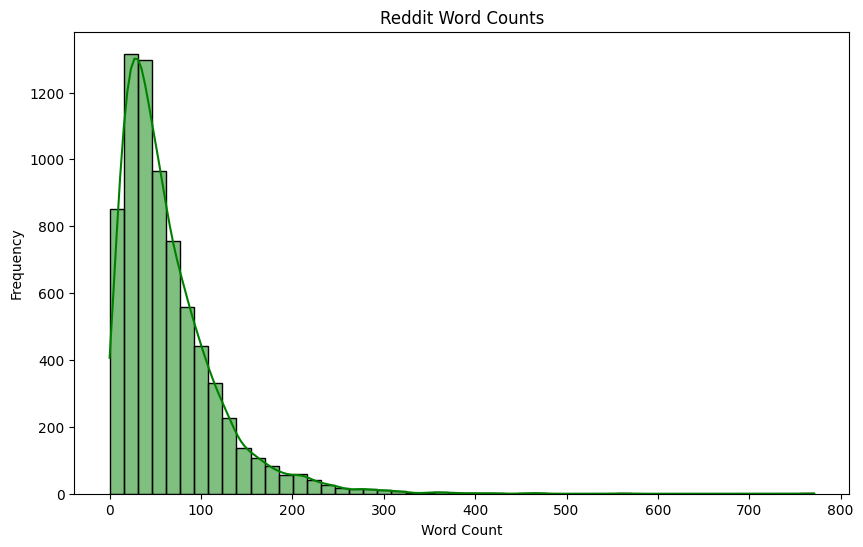

In [75]:
# Plot histogram for word count for Reddit
plt.figure(figsize=(10, 6))
sns.histplot(mh_reddit_clean1['word_count'], bins=50, kde=True, color='green')
plt.title('Reddit Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

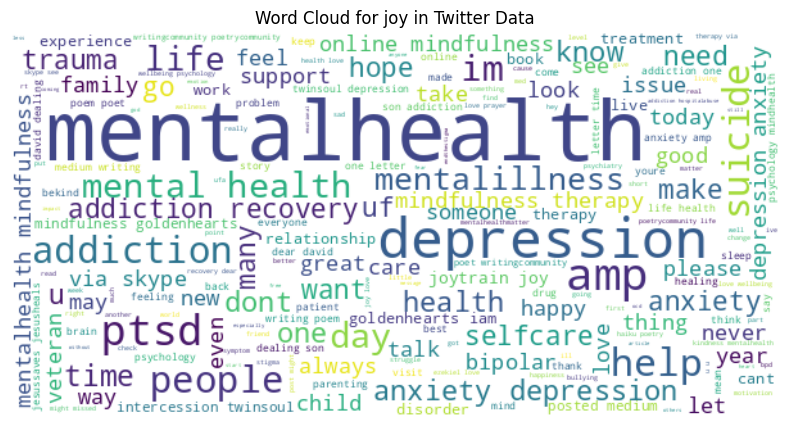

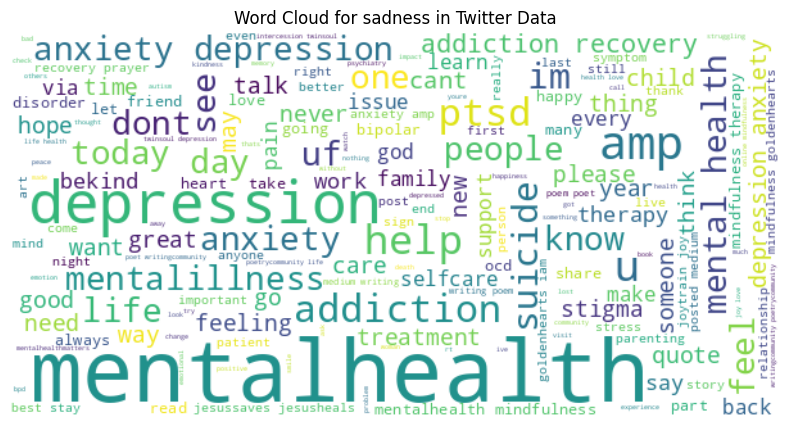

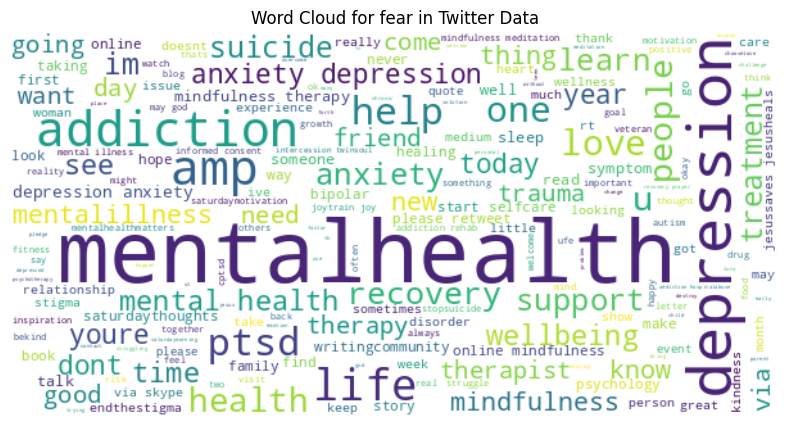

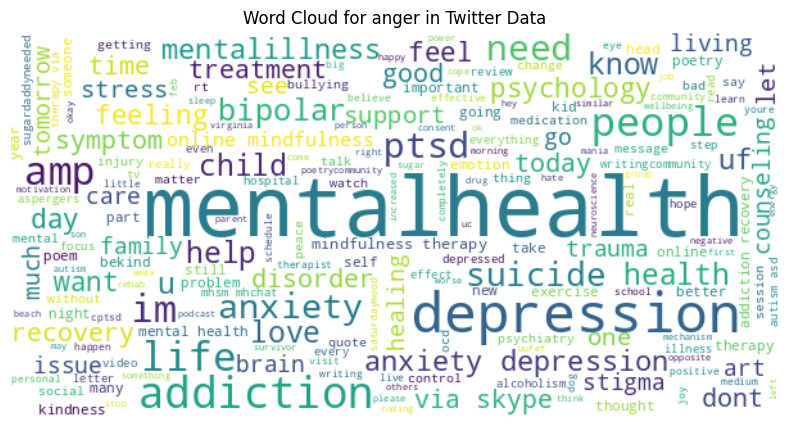

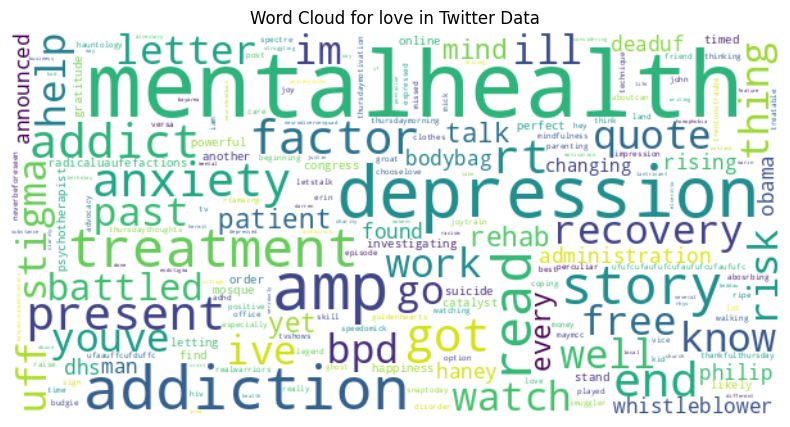

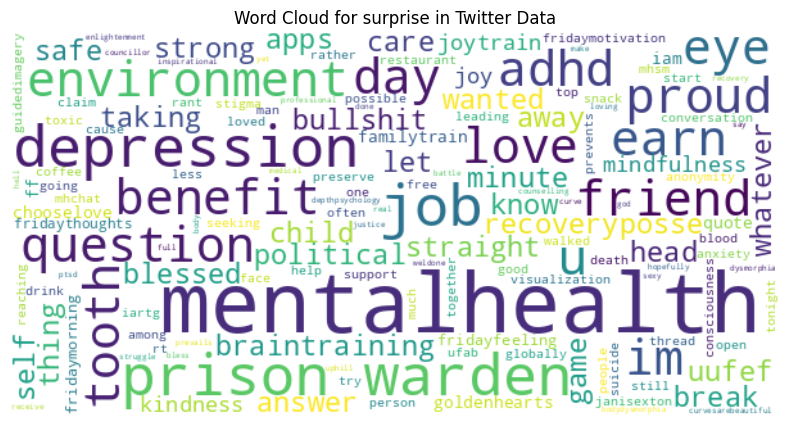

In [76]:
# List of unique emotions
emotions = mh_twitter_clean1['emotion'].unique()

# Generate and plot word clouds for each emotion
for emotion in emotions:
    # Concatenate all texts for the current emotion
    text = ' '.join(mh_twitter_clean1[mh_twitter_clean1['emotion'] == emotion]['clean_text'])

    # Check if text is not empty
    if text.strip():  # Ensure there is some content
        # Generate the word cloud
        wordcloud = WordCloud(width=600, height=300, background_color='white').generate(text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion} in Twitter Data')
        plt.show()
    else:
        print(f"No text available for emotion: {emotion}")


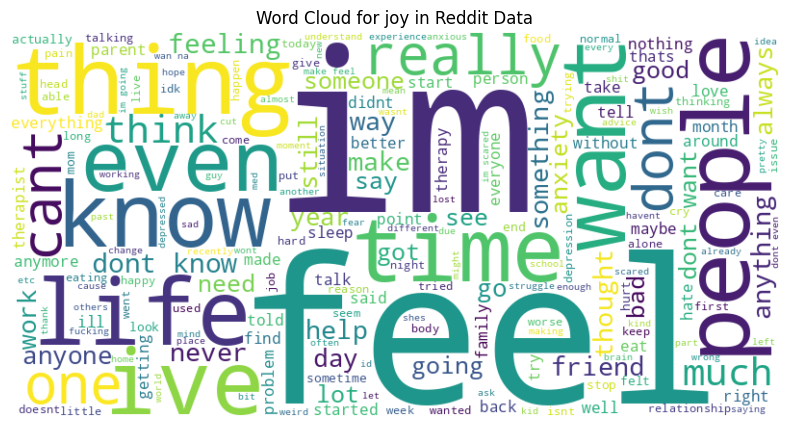

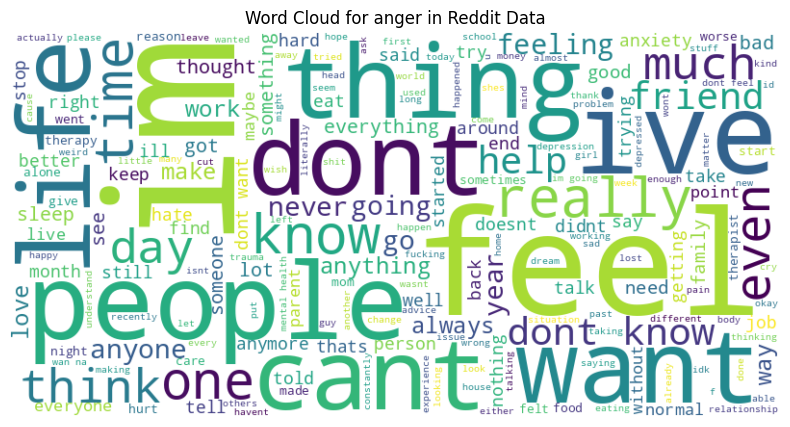

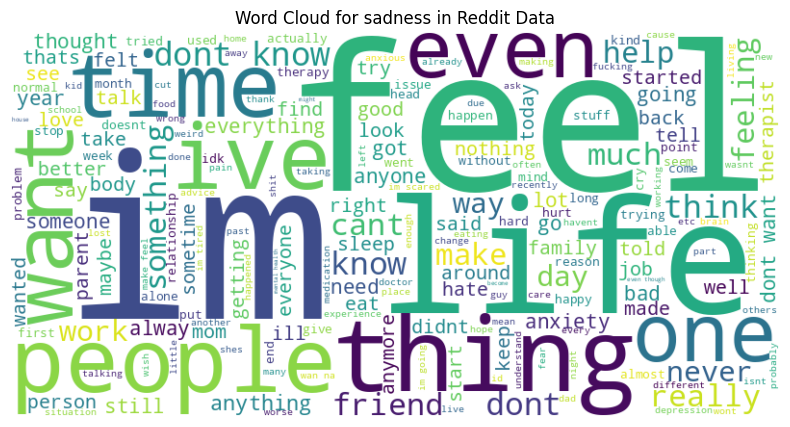

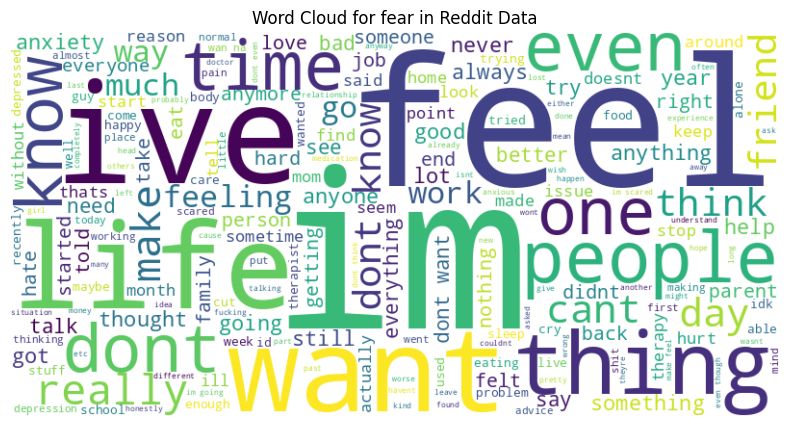

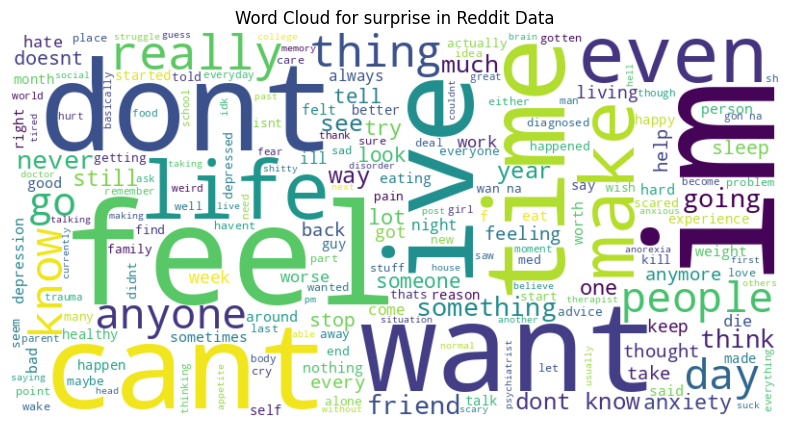

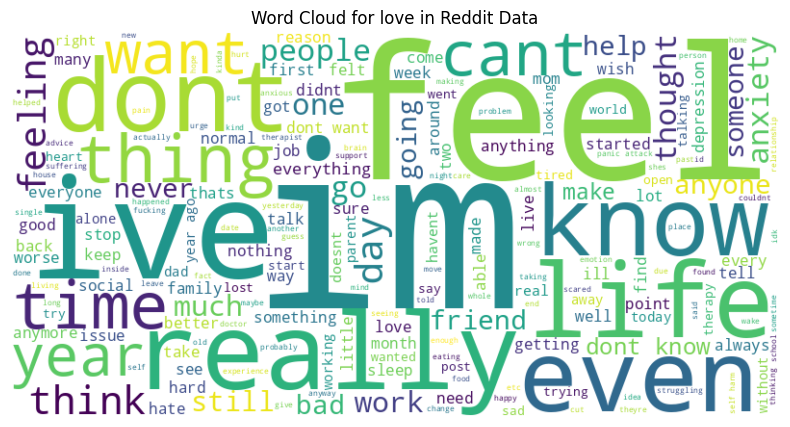

In [77]:
# List of unique emotions for Reddit
emotions_reddit = mh_reddit_clean1['emotion'].unique()

# Generate and plot word clouds for each emotion
for emotion in emotions_reddit:
    # Concatenate all texts for the current emotion
    text = ' '.join(mh_reddit_clean1[mh_reddit_clean1['emotion'] == emotion]['clean_text'])

    # Check if text is not empty
    if text.strip():  # Ensure there is some content
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion} in Reddit Data')
        plt.show()
    else:
        print(f"No text available for emotion: {emotion}")


In [79]:
# Saving cleaned and preprocessed data in csv

mh_reddit_clean1.to_csv('mh_reddit_clean01.csv', index=False)
mh_twitter_clean1.to_csv('mh_twitter_clean01.csv', index=False)